# Noisy generative processes (Chapter 2)

Creates the plot at the beginning of Chapter 2 showing how you can add noise to a linear function to generate points normally distributed across a line.

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

from jax.scipy.stats import norm
from jax import random
from jax.random import normal
from types import SimpleNamespace

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.env_base import Environment

mpl.style.use("seaborn-deep")

## Define the environment and helper functions

First, generate 49 observations from the generative process by using the generating function $y = 2x+3$. The environment is defined in the example such that we have a number of different possible states the environment can be in (defined by `x_true`) and noise will be added to it with `y = Normal(loc=mu, scale=noise)`, where `mu` is the particular true state.

Most of the details in this plot are explained later in Chapter 2, particularly in the notebook `2b_linear_generating_functions.ipynb`.

**Note**: 49 points are chosen because later we make use of the `np.median()` function and we want an odd number of points so we can select a single value for the median.

In [39]:
# Environment specification
class StaticEnvironment(Environment):
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def ge(self, x: float) -> float:
        return self.params.beta_1 * x + self.params.beta_0
    
    def noise(self, x, loc: float, scale: float) -> float:
        # return norm.pdf(x=x, loc=loc, scale=scale)
        return loc + scale * normal(self.params.seed, (1,))
    
    def step(self, x: float) -> float:
        y = self.ge(x) + self.noise(x=x, loc=0, scale=self.params.var_y)
        return y


In [ ]:
# mu + std * jax.random.normal(key, (1000,))

In [46]:
normal()

TypeError: normal() missing 1 required positional argument: 'key'

In [40]:
""" Helper functions """

# Generating function
def ge(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

# Inverse generating function which can return the original state that generated the observation
def ge_inv(y, beta_0, beta_1):
    x = (y - beta_0) / beta_1
    return x

# # Inverse map between y and x
# def x_y_mapping(x ,y, x_val):
#     samples = pd.DataFrame({
#         "x": x, "y": y
#     })
    
#     return samples[samples["x"] == x_val]["y"].values[0]

In [41]:
# Environment parameters
params = {
    "beta_0": 3,   # Linear parameter intercept
    "beta_1": 2,   # Linear parameter slope
    "var_y" : 1,   # Likelihood variance
    "seed"  : random.PRNGKey(4976)  # RNG seed
}

# Simulation setup
x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
n       = 49                                         # Number of samples

# Initialize empty arrays 
y = np.zeros(n)

In [42]:
# Generate 49 random external states
np.random.seed(4932)
x_star = np.random.choice(x_range, size=49)

# Initialize environment and generate data samples
env = StaticEnvironment(params=params)

for idx, x in enumerate(x_star):
    y[idx] = env.step(x)

## Generate data to plot

In [44]:
# # Define the grid (the range of values x can take)
# x_range = np.linspace(start=0.01, end=5, steps=500)

# # Define standard deviation of noise
# noise=1

# # Generate the data and states (y, x)
# data, states = environment(
#     n=49, 
#     x_range=x_range, 
#     noise=noise,
#     beta_0=3,
#     beta_1=2)

# Generate the distribution around noise
point_x = np.median(x_star)     # x coordinate of a chosen sampled point
y_mean = ge(point_x, beta_0=3, beta_1=2)   # y coordinate at chosen sampled point
y_range = np.linspace(start=0.01, stop=12, num=500)
norm_cdf = norm.cdf(y_range, y_mean, params["var_y"])
norm_pdf = np.diff(norm_cdf) / (y_range[1] - y_range[0])   # PDF = derivative of CDF
norm_pdf[norm_pdf == 0] = np.nan
norm_pdf = np.append(norm_pdf, np.NaN)

# Inverse mapping of point_x
point_y = dict(zip(x_star, y))[np.median(x_star)]

## Plot the data points.

The plot is composed of multiple elements:
1. The samples from the noisy generative process. These are just the data points we generated with the `environment()` function.
2. The actual linear generating function (no noise). This is just the line $y= 2x+3$.
3. A normal distribution around a chosen sampled point. This uses the median function to pick a point in the middle of the plot (just so the plot is centered). Then a distribution is drawn around it to indicate that points sampled on the line here could fall in $\pm y$ range. To create the distribution we just create the CDF of the normal distribution at that point and then take the derivative to get the PDF.
4. Dotted "boundary lines" are added to show the $x$ and $y$ coordinates around the point on the line.
5. A red line is drawn to show how the noise has offset the point from the mean.

<Figure size 432x288 with 0 Axes>

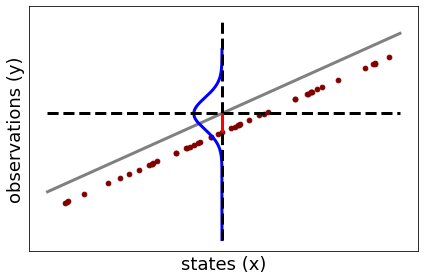

In [45]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Plot (1): Samples from probabilistic generative process
ax.scatter(x_star, y,
           s=22,
           c="maroon")

# Plot (2): Deterministic (linear) generating function
ax.plot(x_range.tolist(), [ge(elem, beta_0=3, beta_1=2) for elem in x_range],
        c="gray",
        linewidth=3)

# Plot (3): Normal distribution around the sampled point
ax.plot(-norm_pdf + ge_inv(y_mean, beta_0=3, beta_1=2), y_range,
        c="blue",
        linewidth=3)

# Plot (4): Boundary lines
ax.hlines(y=y_mean, xmin=0, xmax=5, 
          linestyle="dashed", 
          colors="black", 
          linewidth=3)

ax.vlines(x=ge_inv(y_mean, beta_0=3, beta_1=2), 
          ymin=0, ymax=14, 
          linestyle="dashed", 
          colors="black",
          linewidth=3)

# Plot (5): Error/offset for the samples point
ax.vlines(x=ge_inv(y_mean, beta_0=3, beta_1=2), 
          ymin=point_y, ymax=y_mean, 
          colors="red",
          linewidth=3)

# Axis labels and stylizing
ax.set_xlabel("states (x)", fontsize=18)
ax.set_ylabel("observations (y)", fontsize=18)
ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    left=False,         
    labelbottom=False,
    labelleft=False)

fig.tight_layout()